In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, \
accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import time
import joblib

In [2]:
train_df = pd.read_csv("fraudTrain.csv", index_col=0) 
test_df = pd.read_csv("fraudTest.csv", index_col=0)

In [3]:
print("The number of train samples is ", len(train_df))
print("The number of test samples is ", len(test_df))

The number of train samples is  1296675
The number of test samples is  555719


## Data description
This dataset is a simulated dataset. From the information we saw, there is no missing data. 
is_fraud column labels whether a transcation is a fraud or not. 
Among these features, we don't use trans_num, first, last, unix_time as features for out prediciton model.

In [4]:
print(train_df.dtypes)
print("\nMissing values")
print(train_df.isna().sum())

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

Missing values
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
c

From the rest of features, we  classify them into three categories. 
1. There are 6 Nuemrical features: amt, lat, long, city_pop, merch_lat, merch_long.
2. There are 3 Date time: trans_date_trans_time, dob. 
3. There are 12 Categorical: cc_num,  merchant, category, gender, street, city, state, zip, job. We convert cc_num and zip from int64 to string.

For numerical features, we need to scale them. For categorical features, we need to encode them using one-hot encoding, label encoding, or embedding. 

In [5]:
train_df["cc_num"] = train_df["cc_num"].astype(str)
train_df["zip"] = train_df["zip"].astype(str)
test_df["cc_num"] = test_df["cc_num"].astype(str)
test_df["zip"] = test_df["zip"].astype(str)
test_df_copy = test_df.copy()
print(train_df[["cc_num", "zip"]].dtypes)

cc_num    object
zip       object
dtype: object


## Explotary data visualization

#### Highly imbalanced dataset.

The percentage of fraud transactions is 0.58%


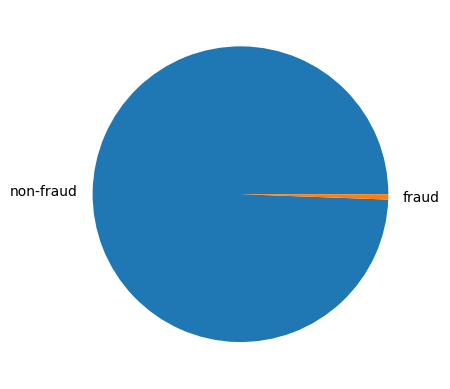

In [6]:
fraud = train_df[train_df["is_fraud"]==1]
non_fraud = train_df[train_df["is_fraud"]==0]
print(f"The percentage of fraud transactions is {(100 * len(fraud)/len(train_df)):.2f}%")
plt.pie([len(non_fraud)/len(train_df), len(fraud)/len(train_df)], labels=['non-fraud', 'fraud'])
plt.show()

Fraud transaction is less than 1 percent of training dataset. Therefore, this is very imbalanced dataset. 

#### Geographic Location of customer and merchant.
As we see in the below figures, the distribution of customer locations is very similar for fraud transactions and non-fraud transactions. The distribution of merchant locations is also very similar for fraud and non-fraud transactions. 

Text(0.5, 1.0, 'Merchant location')

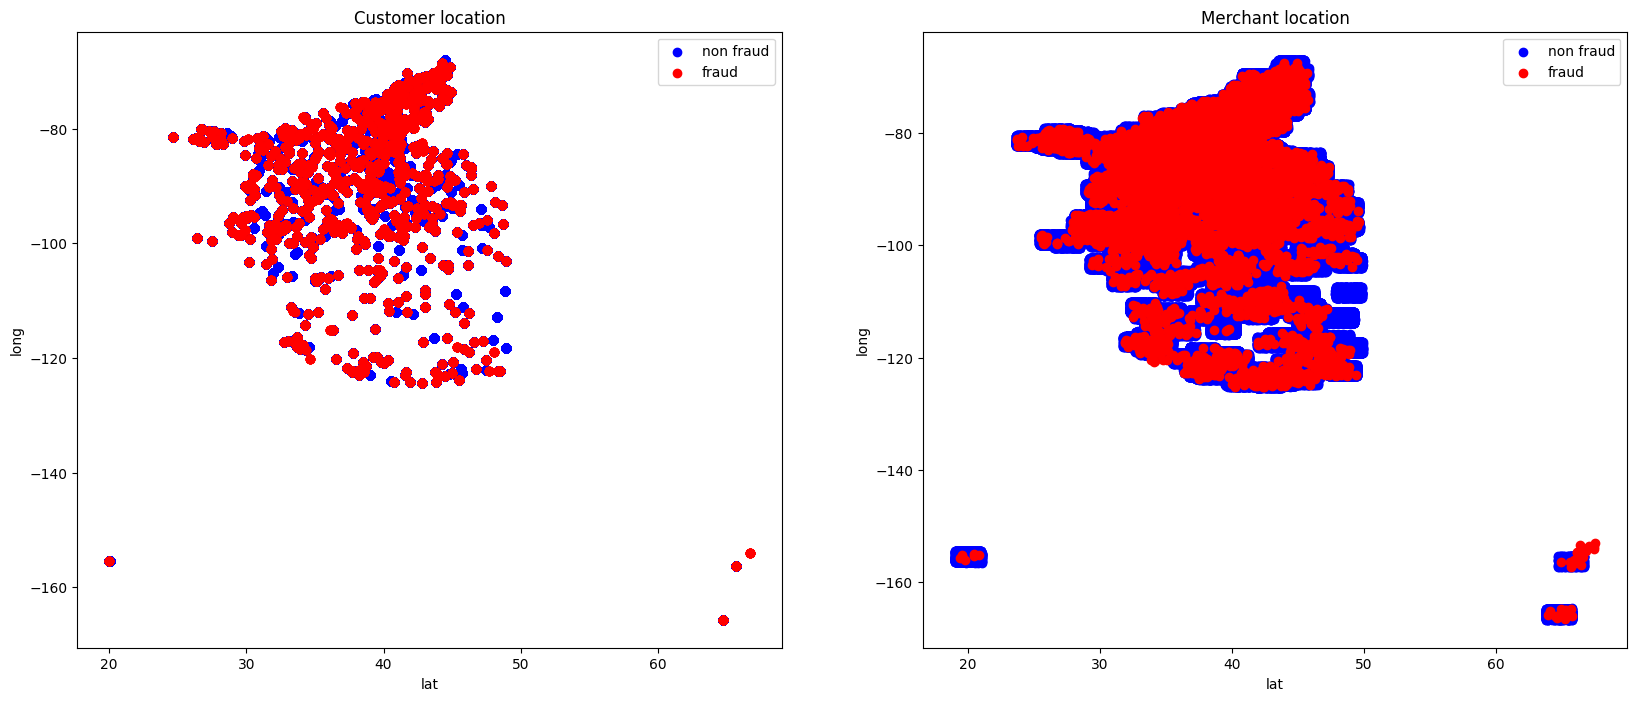

In [7]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(non_fraud["lat"], non_fraud["long"], c='b', label="non fraud")
plt.scatter(fraud["lat"], fraud["long"], c='r', label="fraud")
plt.legend()
plt.xlabel('lat')
plt.ylabel('long')
plt.title('Customer location')

ax2 = fig.add_subplot(1, 2, 2)
plt.scatter(non_fraud["merch_lat"], non_fraud["merch_long"], c='b', label="non fraud")
plt.scatter(fraud["merch_lat"], fraud["merch_long"], c='r', label="fraud")
plt.legend()
plt.xlabel('lat')
plt.ylabel('long')
plt.title('Merchant location')

#### Transaction amount.
We plot the histogram of transaction amount for fraud and non-fraud transactions in linear and log scales. Fraud transactions have a wider distribution,  and has a mode centered at large amount which is absent for non-fraud transactions.

Text(0, 0.5, 'density')

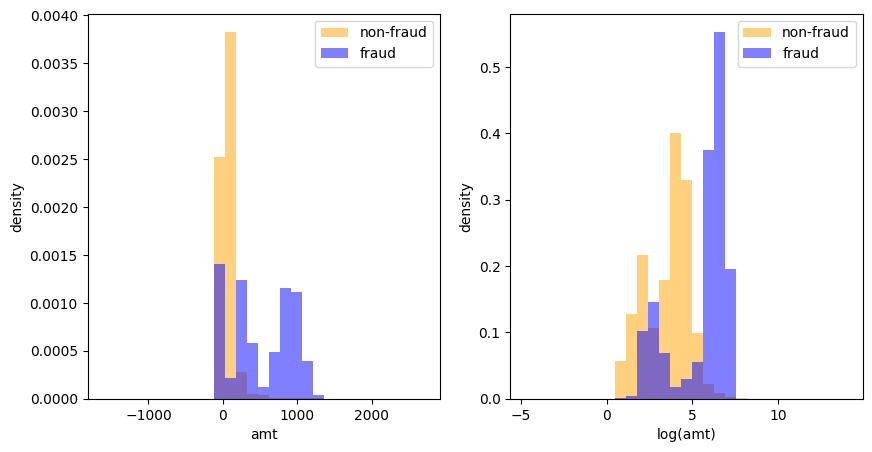

In [8]:
fig = plt.figure(figsize=(10, 5))
q1 = np.percentile(fraud["amt"], 5)
q3 = np.percentile(fraud["amt"], 95)
iqr = q3 - q1
lb, ub = q1 - 1.5 * iqr, q3 + 1.5 * iqr

fig.add_subplot(1,2,1)
plt.hist(non_fraud["amt"], bins=np.linspace(lb, ub, 30), alpha=0.5, label='non-fraud', color='orange', density=True)
plt.hist(fraud["amt"], bins=np.linspace(lb, ub, 30), alpha=0.5, label='fraud', color='blue', density=True)
plt.legend()
plt.xlabel('amt')
plt.ylabel('density')

# Try log amt
q1 = np.percentile(np.log1p(fraud["amt"]), 5)
q3 = np.percentile(np.log1p(fraud["amt"]), 95)
iqr = q3 - q1
lb, ub = q1 - 1.5 * iqr, q3 + 1.5 * iqr
fig.add_subplot(1,2,2)
plt.hist(np.log1p(non_fraud["amt"]), bins=np.linspace(lb, ub, 30), alpha=0.5, label='non-fraud', color='orange', density=True)
plt.hist(np.log1p(fraud["amt"]), bins=np.linspace(lb, ub, 30), alpha=0.5, label='fraud', color='blue', density=True)
plt.legend()
plt.xlabel('log(amt)')
plt.ylabel('density')

#### Category
We plot the percentage of each category for fraud and non-fraud transactions. Fraud mostly occur in the shopping_net and grocery_pos categories, whereas the distribution of non-fraud transactions seem be quite uniform.

In [9]:
fraud_category_percent = fraud.groupby(['category']).count()['cc_num']/len(fraud)
nonFraud_category_percent =  non_fraud.groupby(['category']).count()['cc_num']/len(non_fraud)
fraud_category_percent.sort_values(ascending=True, inplace=True)

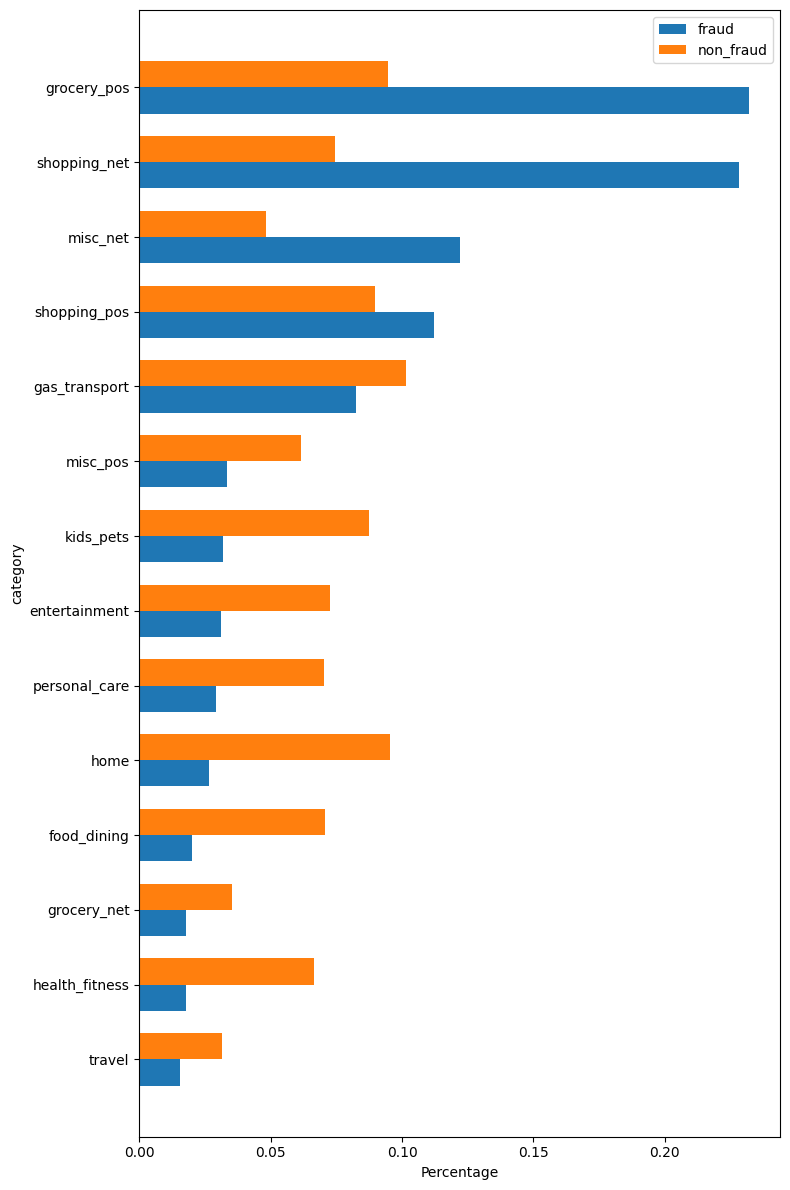

In [10]:
categories = fraud_category_percent.index.values
x = np.arange(len(categories))  # X-axis positions
width = 0.35  # Width of the bars
plt.figure(figsize=(8, 12))
plt.barh(x-width/2, fraud_category_percent.values, width, label='fraud')
plt.barh(x+width/2, nonFraud_category_percent[categories], width, label='non_fraud')
plt.legend()
plt.yticks(x, categories)
plt.ylabel('category')
plt.xlabel('Percentage')
plt.tight_layout()
plt.show()


## Feature Engineering
In order to pass data to most machine learning models, we need to convert non-numerical features into numerical features. 

For categorical variables,
1. Gender is norminal and don't have high cardinality, so we use one-hot encoding.
2. category, merchant, city, state, zip, job are not ordered, we can use either label encoding or target encoding. However, target encoding can lead to overfitting. Therefore, we choose to use label encoding in this project.

For datetime, 
1. For dob, we extract age from this data.
2. For trans_date_trans_time, we extract transaction year, month, day, hour, minute. 
3. From trans_date_trans_time, we can also extract features related transaction recency, which are usually key features to identifying fraud transactions. 

After converting all features into numerical variables, we apply scaling to some of the features.

In [11]:
ONEHOT_ENCODED_FEATURES = ['gender']
LABEL_ENCODED_FEATURES = ['cc_num', 'street', 'city', 'state', 'zip', 'job', 'merchant', 'category']
CATEGORICAL_FEATURES = ONEHOT_ENCODED_FEATURES + LABEL_ENCODED_FEATURES
DATETIME_FEATURES = ["trans_year", "trans_month", "trans_day", "trans_hour", "trans_minute", "trans_second",
                     "age"] #, "time_interval", "time_interval_merchant", "rolling_count_24h", "rolling_amount_24h"]
NUMERICAL_FEATURES = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']
TIME_INTERVAL = 24 * 7

In [12]:
# Group feature transformation
def transform_features(df, onehot_features, label_features, transformations, train=False):
    # One-Hot encoding for gender and category
    for column in onehot_features:
        if train:
            one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_columns = [column  + "_" + x for x in df[column].unique()]
            df[encoded_columns] = one_hot_encoder.fit_transform(df[column].values.reshape(-1, 1))
            transformations[column] = one_hot_encoder
        else:
            encoded_columns = [column + "_" + x for x in transformations[column].categories_[0]]
            df[encoded_columns] =  transformations[column].transform(df[column].values.reshape(-1, 1))
    
    # Label Encoding 
    for column in label_features:
        if train:
            label_encoder = LabelEncoder()
            # Add unknown to deal with unseen labels
            categories = np.concatenate((df[column].values, np.array(['Unknown']))) 
            label_encoder.fit(categories)
            df[column + "_encoded"] = label_encoder.transform(df[column].values)
            transformations[column] = label_encoder
        else:
            categories =  set(transformations[column].classes_.tolist())
            df[column + "_encoded"] = [x if x  in categories else 'Unknown' for x in df[column].values]
            df[column + "_encoded"] = transformations[column].transform(df[column + "_encoded"].values)
#             features.append(columns + "_encoded")
    
            
    df['amt'] = np.log1p(df['amt'])
    
    # Extract user age
    df['dob'] = pd.to_datetime(df['dob'])
    df['year_of_birth'] = df['dob'].dt.year
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['year_of_trans'] = df['trans_date_trans_time'].dt.year
    df['age'] = df['year_of_trans'] - df['year_of_birth']
    
    # Transaction time encoding
    df["trans_year"] = df["trans_date_trans_time"].dt.year - 2019
    df["trans_month"] = df["trans_date_trans_time"].dt.month
    df["trans_day"] = df["trans_date_trans_time"].dt.day
    df["trans_hour"] = df["trans_date_trans_time"].dt.hour
    df["trans_minute"] = df["trans_date_trans_time"].dt.minute
    df["trans_second"] = df["trans_date_trans_time"].dt.second
    
    # Extract the time lapsed since last transaction (in hour) of each cc_num
#     df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
#     df['time_interval'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()/60/60
#     df['time_interval'] = df['time_interval'].fillna(TIME_INTERVAL) # Replace NaN 
    
#     # Extract the time lapsed since last transaction (in hour) of each cc_num, merchant
#     df['time_interval_merchant'] = df.groupby(['cc_num', 'merchant'])['trans_date_trans_time'].diff().dt.total_seconds()/60/60
#     df['time_interval_merchant'] = df['time_interval_merchant'].fillna(TIME_INTERVAL) # Replace NaN 
    
    # Recent transaction pattern in past 24 hours
    # Extract transaction count and total amount for each category in the past 24 hours 
#     df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
#     df['rolling_count_24h'] = (
#         df[['cc_num', 'trans_date_trans_time']].groupby('cc_num', group_keys=False)  # Group by user
#         .apply(lambda group: group.set_index('trans_date_trans_time')  # Set time as index
#         .rolling('24h').count())  # Count transactions in 24h window
#         .reset_index(drop=True)['cc_num'].values  # Reset index to align with the original DataFrame
#     )
#     df['rolling_amount_24h'] = (
#         df[['cc_num', 'trans_date_trans_time', 'amt']].groupby('cc_num', group_keys=False)  # Group by user
#         .apply(lambda group: group.set_index('trans_date_trans_time')  # Set time as index
#         .rolling('24h').sum())  # sum in 24h window
#         .reset_index(drop=True)['amt'].values  # Reset index to align with the original DataFrame
#     )
    
#     # Usual transaction pattern in the past 7 days.
#     # Extract average transaction amount in the past 7 days
#     df['rolling_amount_7d'] = (
#         df[['cc_num', 'trans_date_trans_time', 'amt']].groupby('cc_num', group_keys=False)  # Group by user
#         .apply(lambda group: group.set_index('trans_date_trans_time')  # Set time as index
#         .rolling('7d').mean())  # sum in 24h window
#         .reset_index(drop=True)['amt'].values  # Reset index to align with the original DataFrame
#     )

#     # Extract transaction count for each category in the past 7 days
#     df['rolling_count_7d'] = (
#         df[['cc_num', 'category', 'trans_date_trans_time']].groupby(['cc_num', 'category'], group_keys=False)  # Group by user
#         .apply(lambda group: group.set_index('trans_date_trans_time')  # Set time as index
#         .rolling('7d').count())  # Count transactions in 24h window
#         .reset_index(drop=True)['cc_num'].values  # Reset index to align with the original DataFrame
#     )
#     print(df.columns)
    return df
    
def scale_features(df, scaled_features, scalers, train=False):
    # Scale features 
    for column in scaled_features:
        if train:
            scaler = StandardScaler()
            df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
            scalers[column] = scaler
        else:
            df[column] = scalers[column].transform(df[column].values.reshape(-1, 1))
    return df

In [13]:
# Save train tarnsformers to process test data.
TRAIN_TRANSFORMERS = {}
TRAIN_SCALERS = {}
# Feature engineering for train dataset
train_df = transform_features(train_df, ONEHOT_ENCODED_FEATURES, LABEL_ENCODED_FEATURES, TRAIN_TRANSFORMERS, train=True)

### Using hypothesis testing to select features
The dependent variable is a categorical variable.
1. To test whether there is a relationship between two categorical variables, we use chi square test. 
2. To test whether there is a relationship between a categorical variable with numerical variable, we use anova test. 

In [14]:
from scipy.stats import chi2_contingency, f_oneway
def chi_square_test(df, feature, verbose=False):
    
    contingency_table = pd.crosstab(df[feature], df["is_fraud"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    if verbose:
        print("Testing feature " + feature)
        print("Chi-Square Statistic:", chi2)
        print("p-value:", p)
        # print("Degrees of Freedom:", dof)
        # print("Expected Frequencies:\n", expected)

        # Interpretation
        if p < 0.05:
            print("Reject the null hypothesis: There is a significant association between is_fraud and " + feature)
        else:
            print("Fail to reject the null hypothesis: No significant association.")
    return chi2, p

def anova_test(df, feature, verbose=False):
    # ANOVA Test
    fraud = df[df["is_fraud"]==1]
    nonfraud = df[df["is_fraud"]==0]
    f_val, p_val = f_oneway(fraud[feature].values, nonfraud[feature].values)
    
    # Print the results
    if verbose:
        print("Testing feature " + feature)
        print("f value Statistic:", f_val)
        print("p-value:", p_val)
    
        # Interpretation
        if p_val < 0.05:
            print("Reject the null hypothesis: There is a significant association between is_fraud and " + feature)
        else:
            print("Fail to reject the null hypothesis: No significant association.")
    return f_val, p_val

In [15]:
# Hypothesis Testing
categorical_statistic = []
numerical_statistic = []
datetime_statistic = []

# Hypothesis testing for categorical features
for feature in CATEGORICAL_FEATURES:
    chi2, _ = chi_square_test(train_df, feature)
    categorical_statistic.append((feature, chi2))
    
# Hypothesis testing for numerical features 
for feature in NUMERICAL_FEATURES:
    f_val, _ = anova_test(train_df, feature)
    numerical_statistic.append((feature, f_val))

# Hypothesis testing for numerical features extracted from date time features
for feature in DATETIME_FEATURES:
    f_val, _ = anova_test(train_df, feature)
    datetime_statistic.append((feature, f_val))

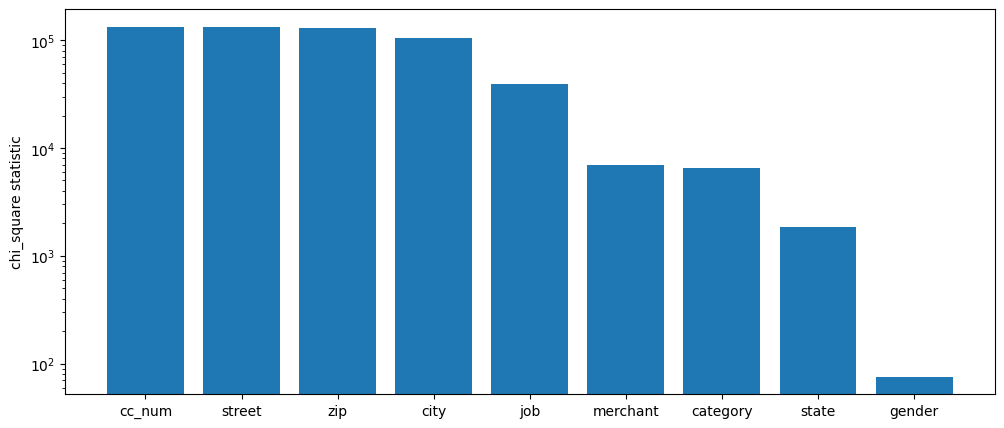

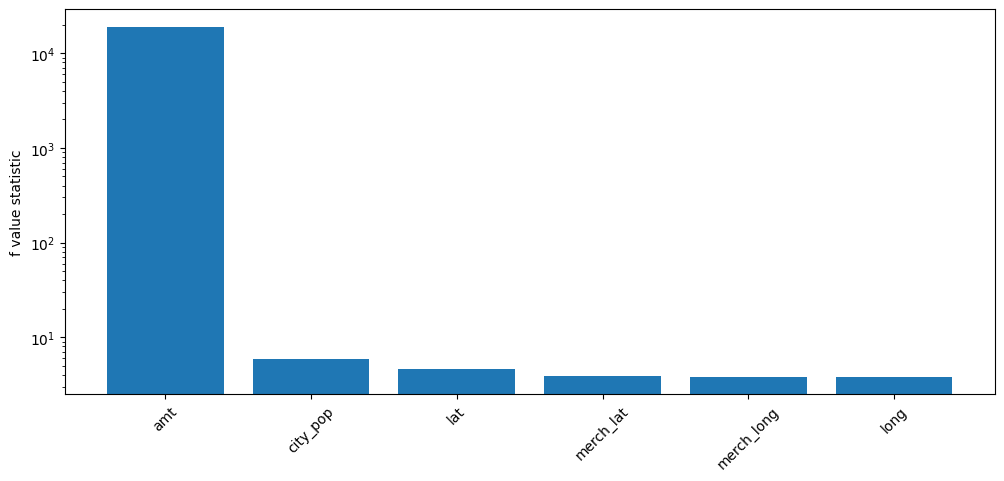

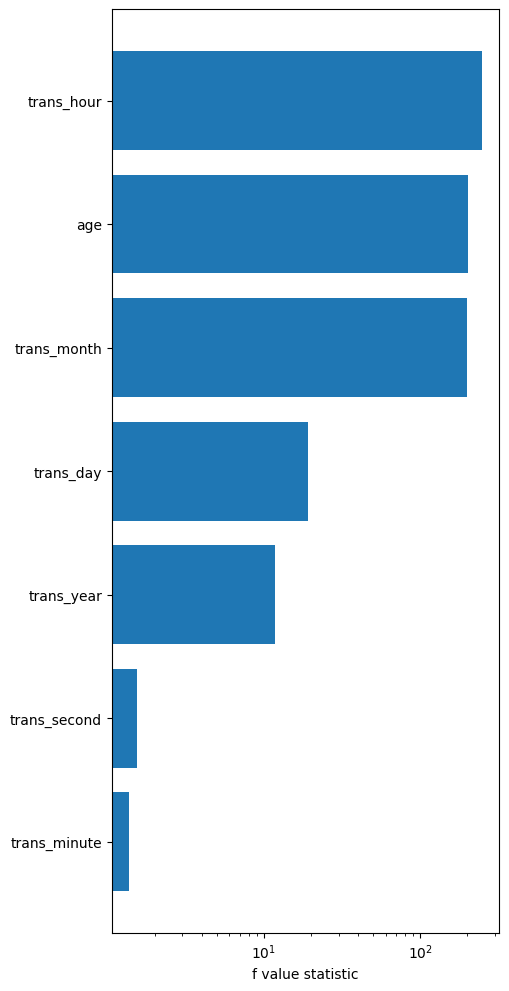

In [16]:
# Sort featuers by statistic in descending order
categorical_statistic.sort(key = lambda x: -x[1])
numerical_statistic.sort(key = lambda x: -x[1])
datetime_statistic.sort(key = lambda x: x[1])

# Plot statistic for categorical variables
plt.figure(figsize=(12, 5))
plt.bar([x[0] for x in categorical_statistic], [x[1] for x in categorical_statistic])
plt.ylabel('chi_square statistic')
plt.yscale('log')

# Plot statistic for numerical variables
plt.figure(figsize=(12, 5))
plt.bar([x[0] for x in numerical_statistic], [x[1] for x in numerical_statistic])
plt.ylabel('f value statistic')
plt.yscale('log')
plt.xticks(rotation=45)

# Plot statistic for transformed date time variables
plt.figure(figsize=(5, 12))
plt.barh([x[0] for x in datetime_statistic], [x[1] for x in datetime_statistic])
plt.xlabel('f value statistic')
plt.xscale('log')

In [17]:
SCALED_FEATURES = ['cc_num_encoded', 'zip_encoded', 
                    'merchant_encoded', 'category_encoded', 'state_encoded'] \
                + ['amt', 'trans_month', 'trans_hour', 'age'] \
               #  + ['time_interval', 'time_interval_merchant', 'rolling_amount_24h', 'rolling_count_24h']

In [18]:
# Scale features for train dataset.
train_df  = scale_features(train_df, SCALED_FEATURES, TRAIN_SCALERS, train=True)

# Transform and scale features for test dataset.
test_df = transform_features(test_df, ONEHOT_ENCODED_FEATURES, LABEL_ENCODED_FEATURES, TRAIN_TRANSFORMERS)
test_df = scale_features(test_df, SCALED_FEATURES, TRAIN_SCALERS)

## Build predictive models
### Over-sampling the minority class
Since the dataset is highly imbalanced, we first over-sample the minority class to get a balanced dataset.

In [19]:
# Over-sampling fraud cases to get a balanced dataset
train_fraud = train_df[train_df["is_fraud"]==1]
train_non_fraud = train_df[train_df["is_fraud"]==0]
train_fraud_sampled = train_fraud.sample(n=len(train_non_fraud), replace=True)
train_df_sampled = pd.concat([train_non_fraud, train_fraud_sampled])
print(f"After over-sampling, number of fraud record is {len(train_df_sampled[train_df_sampled['is_fraud']==1])}.")
print(f"After over-sampling, number of non-fraud records is {len(train_df_sampled[train_df_sampled['is_fraud']==0])}.")

After over-sampling, number of fraud record is 1289169.
After over-sampling, number of non-fraud records is 1289169.


In [20]:
# Split features and target variable
SELECTED_FEATURES = ['cc_num_encoded', 'zip_encoded', 
                    'merchant_encoded', 'category_encoded', 'state_encoded'] \
                + ['amt', 'trans_month', 'trans_hour', 'age'] \
                # + ['time_interval', 'time_interval_merchant', 'rolling_amount_24h', 'rolling_count_24h']

X_train, y_train = train_df_sampled[SELECTED_FEATURES], train_df_sampled['is_fraud']
X_test, y_test = test_df[SELECTED_FEATURES], test_df['is_fraud']

### Create model evaluation function

In [21]:
# Build a function to evalute models
def eval_models(X, y, models):
    for name, model in models.items():
        pred = model.predict(X)
        recall = recall_score(y, pred)
        precision = precision_score(y, pred)
        accuracy = accuracy_score(y, pred)
        cm = confusion_matrix(y, pred)
        print(name)
        print("Accuracy is %.1f%%, Precision is %.1f%%, Recall is %.1f%%" % 
              (100*accuracy, 100*precision, 100*recall))
        print("Confusion Matrix: ")
        print(cm)
    
    plt.figure()
    for name, model in models.items():
        y_scores = model.predict_proba(X)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y, y_scores)
        plt.plot(recall, precision, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


### Logistic regression

In [22]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

### Random forest model

In [26]:
MAX_DEPTH = 17
N_ESTIMATORS = 100
MIN_SAMPLES_LEAF = 20
# MIN_SAMPLES_SPLIT = 40
start_time = time.time()
rf =  RandomForestClassifier(random_state=42, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, 
                             min_samples_leaf=MIN_SAMPLES_LEAF)
rf.fit(X_train, y_train)
print(f"Training Time: {time.time() - start_time:.2f} seconds")

Training Time: 238.43 seconds


In [45]:
# Grid search for optimal parameters
# Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 13, 15],
#     'min_samples_leaf': [10, 20, 40],
# }

# # Initialize the RandomForestClassifier
# rf = RandomForestClassifier(random_state=42)

# # Create a stratified k-fold object
# stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=stratified_kfold, scoring='recall', n_jobs=-1, verbose=2)

# # Fit GridSearchCV on the train data
# grid_search.fit(X_train, y_train)

# # Best parameters and score from GridSearchCV
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)

## Evaluate models

Results for training dataset
Logistic Regression
Accuracy is 79.2%, Precision is 80.4%, Recall is 77.1%
Confusion Matrix: 
[[1047348  241821]
 [ 295012  994157]]
Random Forest
Accuracy is 99.8%, Precision is 99.5%, Recall is 100.0%
Confusion Matrix: 
[[1283059    6110]
 [    152 1289017]]


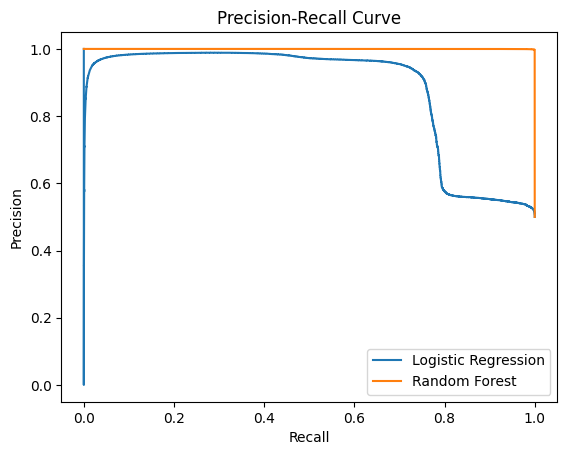

Results for test dataset.
Logistic Regression
Accuracy is 86.9%, Precision is 2.2%, Recall is 75.5%
Confusion Matrix: 
[[481533  72041]
 [   525   1620]]
Random Forest
Accuracy is 99.5%, Precision is 43.9%, Recall is 90.6%
Confusion Matrix: 
[[551092   2482]
 [   201   1944]]


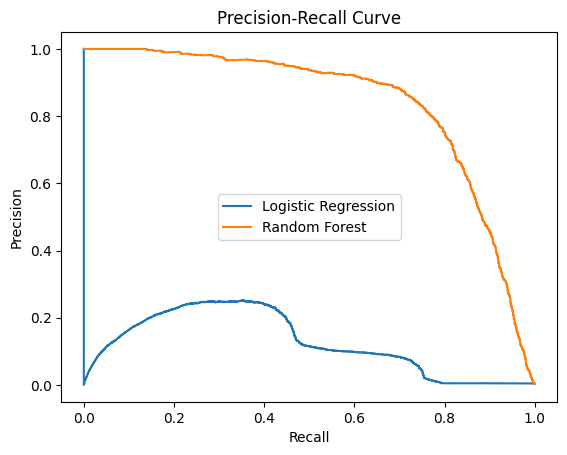

In [27]:
models = {}
models["Logistic Regression"] = logistic_model
models["Random Forest"] = rf
# models['Best Random Forest'] = grid_search.best_estimator_

# Evalute models on training and testing dataset.
print("Results for training dataset")
eval_models(X_train, y_train, models)
print("Results for test dataset.")
eval_models(X_test, y_test, models)

In [28]:
# Save best model
best_model = models['Random Forest']

## Feature importance

<BarContainer object of 9 artists>

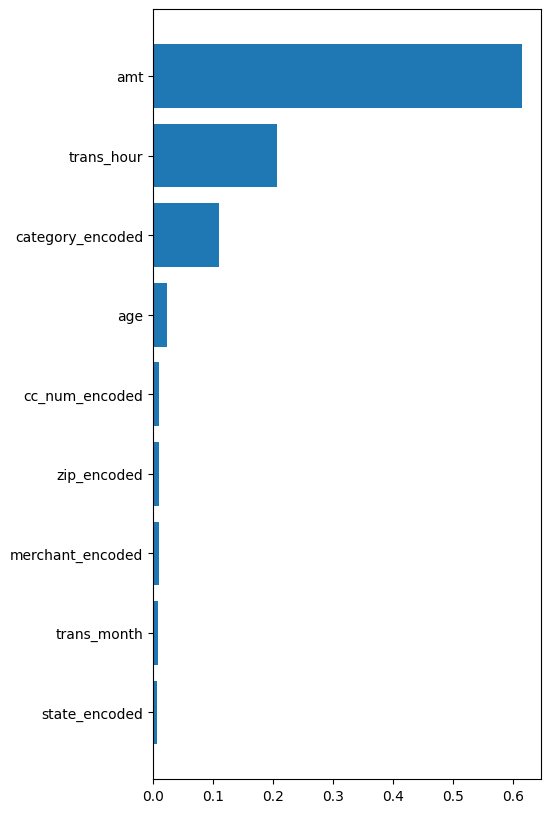

In [29]:
plt.figure(figsize=(5, 10))
feature_importance = [(x, y) for x, y in zip(SELECTED_FEATURES, best_model.feature_importances_)]
feature_importance.sort(key=lambda x: x[1])
plt.barh([x[0] for x in feature_importance[0:20]], [x[1] for x in feature_importance[0:20]])

# Build a pipeline for prediction

In [30]:
# class Imputer(BaseEstimator, TransformerMixin):
#     # Check Input and Fill in missing values
#     def fit(self, X):
#         return self
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureTransformer(BaseEstimator, TransformerMixin):
    # Feature Engineering
    def __init__(self, transform_function, onehot_features, label_features, train_transformers):
        self.transform_function = transform_function
        self.onehot_features = onehot_features
        self.label_features = label_features
        self.train_transformers = train_transformers
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        X = self.transform_function(X, self.onehot_features, self.label_features, self.train_transformers)
        return X

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self,  scale_function, feature_scaler, scaled_features):
        self.scale_function = scale_function
        self.feature_scaler = feature_scaler
        self.scaled_features = scaled_features
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        X = self.scale_function(X, self.scaled_features, self.feature_scaler)
        return X
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_use):
        self.features_to_use = features_to_use

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features_to_use]

In [31]:
# Create a pipeline that includes preprocessing and the model
pipeline_ONEHOT_ENCODED_FEATURES = []
pipeline_LABEL_ENCODED_FEATURES = ['cc_num',  'state', 'zip',  'merchant', 'category']

pipeline = Pipeline([
#     ('imputer', Imputer()),
    ('featureTransformer', FeatureTransformer(transform_features, pipeline_ONEHOT_ENCODED_FEATURES, pipeline_LABEL_ENCODED_FEATURES,
                                             TRAIN_TRANSFORMERS)),
    ('featureScaler', FeatureScaler(scale_features, TRAIN_SCALERS, SCALED_FEATURES)),
     ('featureSelector', FeatureSelector(SELECTED_FEATURES)),
       ('classifier', best_model)
])


# Test the correctness of the pipeline

In [32]:
# Test pipeline
# Make predictions on test dataset
X_test = test_df_copy.drop(columns=['is_fraud'])
y_test = test_df_copy['is_fraud']
y_test_predict = pipeline.predict(X_test)
# Print Metrics
recall = recall_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict)
accuracy = accuracy_score(y_test, y_test_predict)
cm = confusion_matrix(y_test, y_test_predict)
print(f"Accuracy is {100*accuracy: .0f}%, Precision is {100*precision: .0f}%, Recall is {100*recall: .0f}%")
print("Confusion Matrix: ")
print(cm)

Accuracy is  100%, Precision is  44%, Recall is  91%
Confusion Matrix: 
[[551092   2482]
 [   201   1944]]


In [33]:
# Save pipeline
import pickle
with open ('encoders.pkl', 'wb') as f:
    pickle.dump(TRAIN_TRANSFORMERS, f)
with open ('scalers.pkl', 'wb') as f:
    pickle.dump(TRAIN_SCALERS, f)
joblib.dump(pipeline, '../fraud_detection_api/fraud_detection_model.pkl')

['../fraud_detection_api/fraud_detection_model.pkl']

In [70]:
# Examples used to test the pipeline
# test_df_copy[(y_test_predict==1) & (y_test == 1)]